# 1. IMDB intro

IMDB는 영화에 대한 여러 정보를 제공하는 웹사이트입니다. 이 웹사이트에서 작성된 리뷰들은 감정분석에서 사용되는 대표적인 데이터셋으로 유명하죠.

이번 과제에서는 Kaggle의 Bag of Words Meets Bags of Popcorn이라는 **감성분석** 튜토리얼을 진행해볼 것입니다.

참고: https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview

지난 예습과제에서는 한국어 데이터를 만져보았다면, 이번 데이터는 영어 데이터입니다. 두 언어 간 차이로 인해 전처리 과정에서도 미묘한 차이가 존재합니다.

주어지는 데이터셋은 train set과 test set 모두 25,000개의 긍정 부정 리뷰로 구성되어 있으며, 긍정인 경우엔 label이 1이고, 부정인 경우엔 label이 0입니다.

# 2. Load Files

구글 드라이브에 다운받은 파일을 저장하고, 파일을 불러온다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import matplotlib as plt

In [ ]:
train = pd.read_csv('<Fix by yourself>', header=0, delimiter='\t', quoting=3)
test = pd.read_csv('<Fix by yourself>', header=0, delimiter='\t', quoting=3)
submit = pd.read_csv('<Fix by yourself>')



---



# 3. 간략한 데이터 탐색

In [ ]:
train.info()

In [ ]:
train.head()

In [ ]:
test.info()

In [ ]:
test.head()

긍정, 부정 label은 각각 12,500개로 동일하다는 것을 알 수 있습니다.

In [ ]:
train['sentiment'].value_counts()

# 4. Text Preprocessing

## 4-1. html 태그 제거
첫번째 review를 보면 특이점이 있습니다. 바로 `<br>`이라는 html 줄바꿈 태그가 보인다는 점입니다. 첫번째 review뿐만 아니라 다른 review들에도 이러한 태그가 존재할 가능성이 있습니다. 따라서 `BeautifulSoup`를 이용하여 분석에 방해가 되는 태그들은 지워주도록 합시다.

In [ ]:
train["review"][0]

In [ ]:
from bs4 import BeautifulSoup

위 리뷰를 soup 객체로 바꿔주면, html 태그를 제외하고 text만 온전히 추출하는 작업이 가능합니다. 이 기능을 해주는 것이 `get_text()`입니다. 첫번째 리뷰를 하나의 예시로 들어봅시다. 윗문장이 제거 전, 아래문장이 제거 후입니다.


In [ ]:
example1 = BeautifulSoup(train["review"][0])
example1 = example1.get_text()
print("before deleting:", train['review'][0])
print("after deleting:", example1)

## 4-2. 정규표현식(re)으로 알파벳만 남기기

html 태그는 제거했지만, 각종 특수문자가 아직도 남아있습니다. 이는 분석에 불필요한 정보입니다. 알파벳만 남기고 싶다면 정규표현식(regular expression)을 사용하면 됩니다.

'알파벳이 아닌 것'을 '공백'으로 대체하면 될 것입니다. 이러한 기능을 가진 함수는 `re.sub(대체할 패턴, 대체 이후, 대체할 범위)`입니다.


### **Q1) 아래 letters_only를 통해 example1에서 알파벳을 제외한 나머지 글자를 알파벳만 남길수 있도록 공백으로 대체하세요**

In [ ]:
import re
'''
문제 1: 아래 letters_only를 통해 example1에서 알파벳을 제외한 나머지 글자를 알파벳만 남길수 있도록 공백으로 대체하세요.
'''
letters_only = '<Fill in this code>' ## 코드 채우기 문제입니다.

In [ ]:
train['review'][0]

In [ ]:
letters_only

## 4-3. 토큰화(Tokenizing)

토큰(token)은 의미를 갖는 최소 분석 단위입니다. **토큰화(tokenizing)** 는 corpus 덩어리를 작은 토큰 단위로 쪼개어주는 작업입니다. 영어에서는 대체로 띄어쓰기를 기준으로 토큰화를 합니다.

즉 아래처럼 `split()` 함수를 써주기만 하면 띄어쓰기(단어) 단위로 토큰화가 진행될 것입니다. 아래 예시를 통해 하나의 문장에서 437개의 단어로 토큰화된 것을 확인할 수 있습니다.

`lower_case` 함수로 소문자로 변환하는 이유는 무엇일까요? 대문자와 소문자는 다른 단어로 구분되기에 이를 그대로 두면 복잡성을 야기할 수 있습니다. 따라서 단어집합 크기를 최대한 줄이기 위해 대소문자를 통합하는 것입니다.

물론 무작정 소문자로 통합하는 것도 지양해야하는 것이, 미국을 뜻하는 US와 우리를 뜻하는 us는 엄밀히 다르기 때문입니다.

In [ ]:
lower_case = letters_only.lower()
token_words = lower_case.split()
print("토큰화 이후 생성된 토큰(단어) 개수: ",len(token_words))

참고) nltk와 케라스에서 토큰화를 수행해주는 도구들을 제공합니다. 이 도구들은 아포스트로피가 들어간 단어들을 지혜롭게 토큰화해줍니다. 본 과제에서는 앞서 정규표현식으로 아포스트로피를 모두 제거했기에 굳이 아래 도구들을 사용하지 않고 `split()`로만 토큰화를 수행했습니다.

In [ ]:
# from nltk.tokenize import word_tokenize
# word_tokenize(lower_case)
# from nltk.tokenize import WordPunctTokenizer
# WordPunctTokenizer().tokenize(lower_case)
# from tensorflow.keras.preprocessing.text import text_to_word_sequence
# text_to_word_sequence(lower_case)

## 4-4. 불용어(Stopword) 제거

단어를 기준으로 토큰화를 완료했습니다. 이제 이 단어들 중에서 무의미한 것들을 제거하는 작업이 필요합니다. 예컨대 I, we, you, our 등 굉장히 자주 등장하지만 분석에서 크게 중요하지 않은 단어들을 무의미한 단어로 볼 수 있습니다.

이처럼 무의미한 단어들을 **불용어(Stopword)** 라고 부릅니다.

`nltk`에서는 영어의 불용어들을 제공해줍니다. 내장된 불용어의 개수는 179개입니다. 예시 리뷰에서 이 불용어들을 제거해주고 나니 437개였던 토큰이 219개로 확 줄어들었습니다.

In [ ]:
import nltk
nltk.download("stopwords")

In [ ]:
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
print("nltk에 내장된 불용어 개수: ", len(stopwords_list))
print("불용어 예시: ", stopwords_list[:10])
non_stopwords = [w for w in token_words if not w in stopwords_list]
print("예시 review에서 불용어 제거하고 남은 토큰 개수: ",len(non_stopwords))

## 4-5. 어간 추출(Stemming)

nltk에선 단어에서 어간을 추출해주는 도구를 제공합니다. 하지만 이 어간 추출의 작업은 정확히 어간만 추출하는 것이 아니라 정해진 규칙에 따라 임의로 어미를 떼어놓는 작업이기에 100% 정확하게 어간만 추출하지는 못합니다.

nltk의 포터 알고리즘의 규칙은 다음과 같습니다.
- ALIZE → AL
- ANCE → 제거
- ICAL → IC

이라는 규칙에 따라 어간을 추출합니다.

예시를 들어보면, 아래와 같은 어간 추출을 합니다.

- formalize → formal
- allowance → allow
- electricical → electric

출처: 딥러닝을 이용한 자연어 처리 입문 위키독스(https://wikidocs.net/21707)

In [ ]:
from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer()
stemmed_words = [porter_stemmer.stem(w) for w in non_stopwords]

## 4-6. 표제어 추출(Lemmatization)

표제어 추출도 어간 추출과 마찬가지의 역할을 수행한다. 이 둘은 본질적인 차이를 갖는데, Stemming은 단어 그 자체만을 고려하지만 Lemmatization은 그 단어가 문장 속에서 어떤 품사(Part-of-speech)로 쓰였는지까지 판단한다는 점이다. 따라서 Lemmatization이 보다 복잡한 처리 과정을 거칠 수밖에 없다.

kaggle의 다른 여러 코드들을 참고한 결과 stemming을 하는 것보다 lemmatization을 하는 것이 더 나은 결과를 도출하는 것 같아서 lemmatization만 수행하도록 하겠다.

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
lemmatized_words = [wordnet_lemmatizer.lemmatize(w) for w in non_stopwords]
lemmatized_words = [wordnet_lemmatizer.lemmatize(w,"v") for w in lemmatized_words]

In [ ]:
print(non_stopwords[21:40]) # none
print(stemmed_words[21:40]) # stemming
print(lemmatized_words[21:40]) # lemmatization

## 4-7. 하나의 함수로 표현

앞선 6가지의 전처리 과정을 하나의 함수로 통합합니다.

In [ ]:
stopwords_list = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def review_to_words(raw_review):
  except_tag = BeautifulSoup(raw_review).get_text() # html 태그 제거
  letters_only = re.sub("[^a-zA-Z]", " ", except_tag) # 알파벳만 남기기
  token_words = letters_only.lower().split() # 소문자로 통합하고 단어 단위로 토큰화
  non_stopwords = [w for w in token_words if not w in stopwords_list] # 불용어 삭제
  lemmatized_words = [wordnet_lemmatizer.lemmatize(w) for w in non_stopwords]
  lemmatized_words = [wordnet_lemmatizer.lemmatize(w,"v") for w in lemmatized_words] # Lemmatization
  words = " ".join(lemmatized_words)
  return words



---



# 5. BoW(Bag of Words) 형태로 변환

Bag of words는 단어의 출현 빈도에 집중하여 텍스트를 수치화하는 표현 방식입니다.

예를 들어 아래처럼 두 개의 노래 구절이 있는 경우

```python
lyric1 = "but I don't want to stay in the middle"
lyric2 = "like you a little don't want no riddle"
```

아래 같은 단어 모음이 만들어지고

```python
vocab = ["but", "I", "don't", "want", "to", "stay", "in", "the", "middle", "like", "you", "a", "little", "no", "riddle"]
```

아래처럼 단어들을 빈도로 수치화할 수 있습니다.

```python
lyric1 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
lyric2 = [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
```

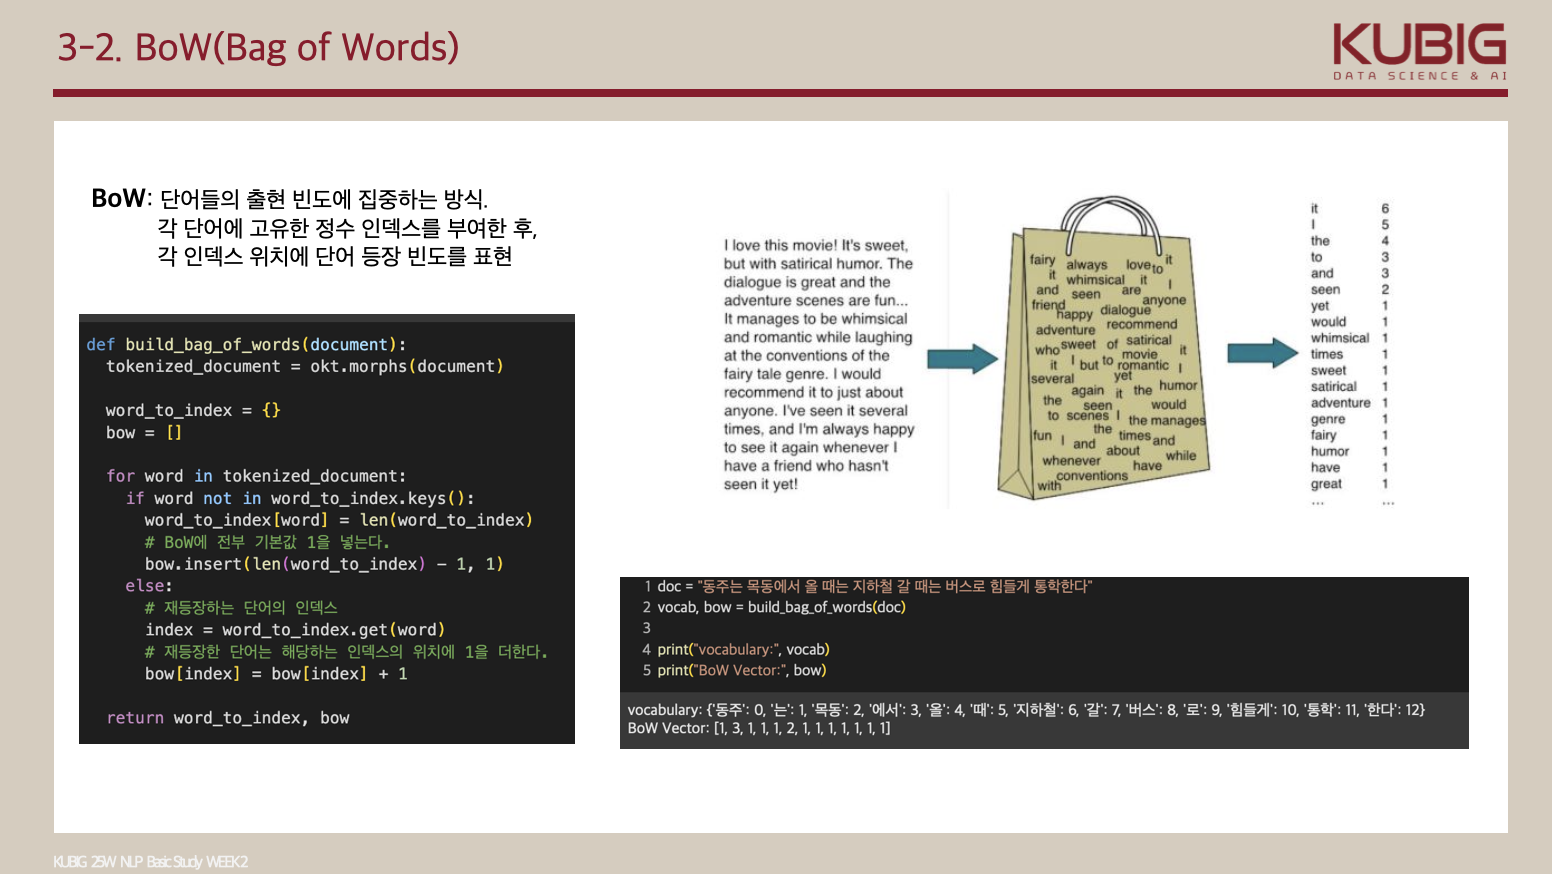

위 같은 작업을 사이킷런의 `CountVectorizer`가 수행해줍니다.

In [ ]:
num_reviews = train['review'].size

clean_train_reviews = []
for i in range(0, num_reviews):
     if (i + 1) % 5000 == 0 :  #실행이 잘되는지 확인하기 위해 5000개 실행될때마다 확인문구
         print('Review {} of {}'.format(i+1, num_reviews))
     clean_train_reviews.append(review_to_words(train['review'][i]))

`clean_train_reviews`에는 25,000개의 전처리된 리뷰들이 담겨있습니다. 이것을 `CountVectorizer에` input으로 넣어주면 BoW가 완성됩니다.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 학습 단위
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 2), # 단어의 묶음 개수
                             max_features = 4000) # 토큰의 최대 개수, 즉 컬럼의 최대 개수

# 6. TfidfVectorizer

이번엔 `CounterVectorizer`보다 한 단계 나아간 `TidfVectorizer`에 대해 살펴볼 것입니다.

`TidfVectorizer()`는 TF-IDF(단어빈도*문서빈도역수)를 학습시키는 함수입니다. 단어빈도란 특정 단어가 한 문서 내에서 출현한 빈도이고, 문서빈도는 특정 단어가 출현한 전체 문서의 개수입니다.

왜 두 빈도를 모두 알아야 할까요? 예컨대 정관사 a, the는 영어에서 굉장히 많이 쓰입니다. 하지만 출현빈도에 비해 그렇게 중요치 않은 단어입니다. 이처럼 단어빈도는 높아도 중요도가 낮은 단어들을 걸러주기 위해 이 단어가 출현한 문서의 빈도도 카운트해줄 필요가 있다는 얘기입니다.

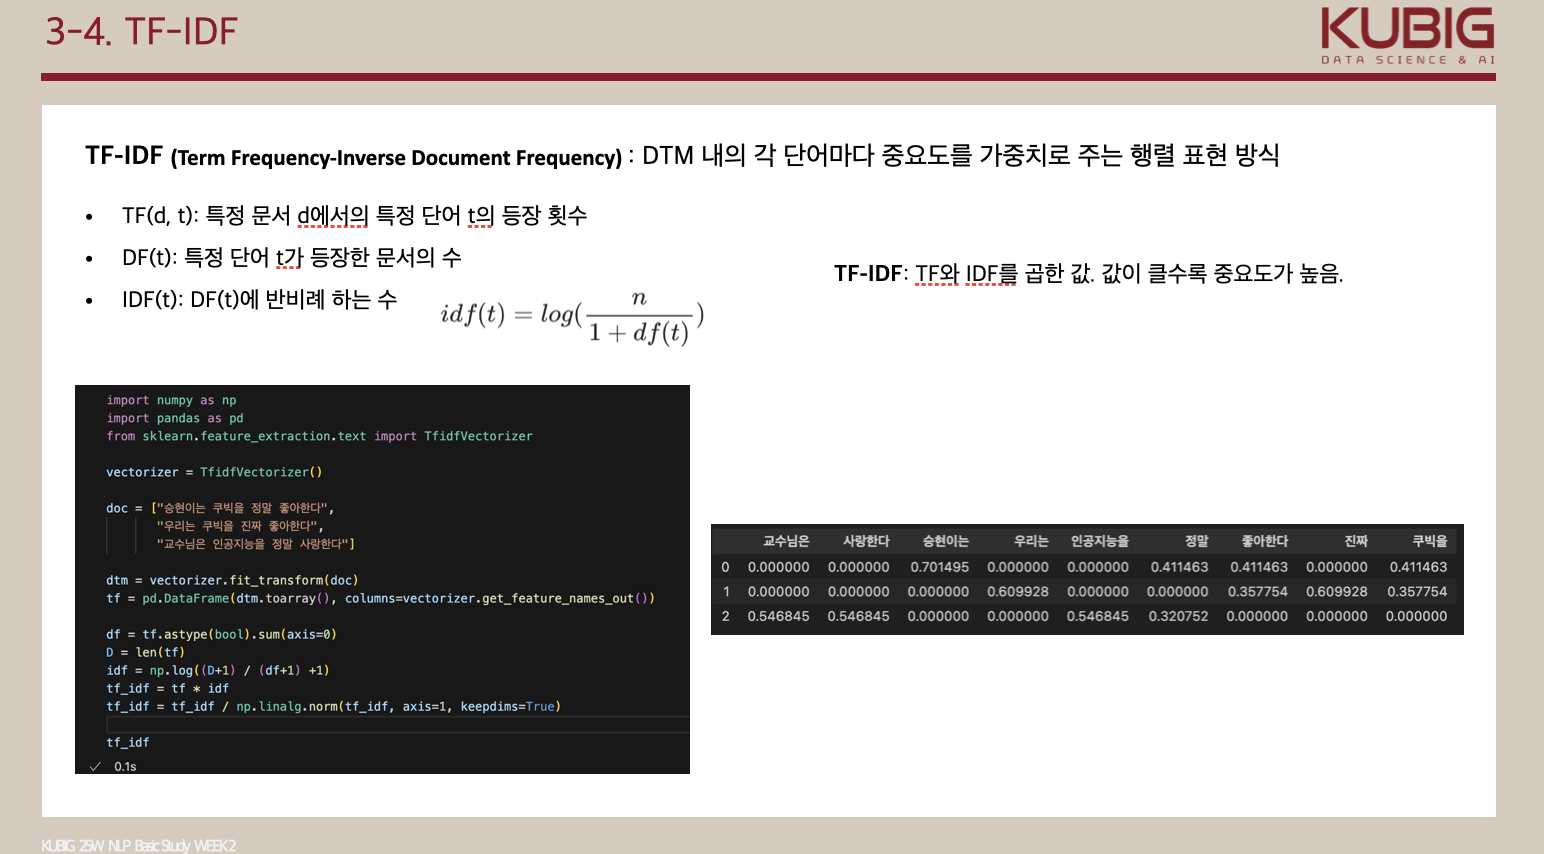

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 4, # 토큰이 나타날 최소 문서 개수
                             analyzer = 'word', # 학습 단위
                             ngram_range = (1, 2), # 단어의 묶음 개수
                             max_features = 1000) # 토큰의 최대 개수, 즉 컬럼의 최대 개수

In [ ]:
train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features.shape

(25000, 1000)

`TfidfVectorizer`의 `get_feature_names_out()` 메서드로 토큰 이름들을 추출할 수 있습니다.

cf) scikit-learn 0.24.0 이상에선 `get_feature_names_out()`, 미만에선 `get_feature_names()`

In [ ]:
vocab = vectorizer.get_feature_names_out()
vocab[:10]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abandon',
 'abc',
 'ability',
 'able',
 'abraham',
 'absence',
 'absolute',
 'absolutely',
 'absolutely love',
 'absolutely nothing']

# 7. Modeling

baseline 코드로 제시된 트리 계열 알고리즘으로 학습을 시켜봅니다.

원하시는 경우 성능 향상을 위해 새롭게 코드를 짜보셔도 좋습니다!

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

x = train_data_features
y = train['sentiment']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

# 트리 알고리즘 3개를 사용
rf = RandomForestClassifier(n_estimators = 200,
                            n_jobs = -1,
                            random_state=42,
                            max_depth=20)

xgb = XGBClassifier(n_estimators=200,
                    max_depth=10,
                    learning_rate=0.05,
                    objective='binary:logistic')

lgbm = LGBMClassifier(n_estimators=200,
                    max_depth=10,
                    metric='binary_logloss')

In [ ]:
xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict_proba(x_val)

In [ ]:
lgbm.fit(x_train, y_train)
y_pred_lgbm = lgbm.predict_proba(x_val)

In [ ]:
rf.fit(x_train, y_train)
y_pred_rf = rf.predict_proba(x_val)

학습된 모델들의 `roc_auc_score`는 아래처럼 구할 수 있다.

In [ ]:
print('Random Forest AUC Score :', roc_auc_score(y_val, y_pred_rf[:,1]))
print('XGBoost AUC Score :', roc_auc_score(y_val, y_pred_xgb[:,1]))
print('LGBM AUC Score :', roc_auc_score(y_val, y_pred_lgbm[:,1]))

# 8. test set 추론

In [ ]:
num_reviews = test['review'].size

clean_test_reviews = []
for i in range(0, num_reviews):
     if (i + 1) % 5000 == 0 :  #실행이 잘 되는지 확인하기 위해 5000개 실행될때마다 확인문구
         print('Review {} of {}'.format(i+1, num_reviews))
     clean_test_reviews.append(review_to_words(test['review'][i]))

In [ ]:
test_data_features = vectorizer.fit_transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

In [ ]:
# 3개 알고리즘 중 원하는 것으로 predict
result = lgbm.predict(test_data_features)
submit['sentiment'] = result

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
submit.head(10)

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,1
4,12128_7,0
5,2913_8,0
6,4396_1,0
7,395_2,1
8,10616_1,0
9,9074_9,0


원하시는 분은 직접 결과 제출도 해보세요!

https://www.kaggle.com/competitions/word2vec-nlp-tutorial/submissions

In [ ]:
submit.to_csv("./submission_240117.csv", index=False)